# Abnormal detection of Chip Temperature Time Series

In [1]:
import os
import numpy as np
import keras
import pickle
import pandas as pd
from keras.utils import plot_model
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Input
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


# 1. Pre-processing chip temperature data

In [2]:
# Step 1. Read chip temperature data from CSV file
temp_base_data = pd.read_csv('data/temp_data.csv')
print(temp_base_data.shape)

(8000, 643)


In [3]:
# Step 2. Divide data into time series data based on burn-in board coordinates
temp_data = temp_base_data.pivot(index='ID', columns='Time(min)')
print(temp_data.shape)
#print(type(temp_data))


(400, 12820)


In [4]:
# Rename column name as string value
data_cols = list(temp_data.columns)
print(data_cols[0:1])
cols_name_list = ['{0}_{1}'.format(col_item[0], col_item[1]) for col_item in data_cols]
print(cols_name_list[0:1])
temp_data.columns = cols_name_list
print(len(list(temp_data.columns)))

[('(0,0)', 0)]
['(0,0)_0']
12820


In [5]:
def combine_ts_to_list():
    # Combine time series data as list
    num_index = 0
    for x_num in range(32):
        for y_num in range(20):
            num_index += 1

            pos_mark = '({0}, {1})'.format(x_num, y_num)
            print('pos_mark: {0}'.format(pos_mark))

            start_col_index = y_num * 40

            time_series_cols_list = cols_name_list[start_col_index:start_col_index + 20]
            #print(time_series_cols_list[0])
            temp_data[pos_mark] = temp_data[time_series_cols_list].values.tolist()  

    # Combine OvenTemp time series
    pos_mark = 'OvenTemp'
    print('pos_mark: {0}'.format(pos_mark))
    start_col_index = 20 * 20
    time_series_cols_list = cols_name_list[start_col_index:start_col_index + 20]
    #print(time_series_cols_list[0])
    temp_data[pos_mark] = temp_data[time_series_cols_list].values.tolist()    

    # Remove unused columns
    temp_data = temp_data.drop(cols_name_list, axis=1)        
    print(temp_data.shape)

In [6]:
# Step 3. Check Null value

null_value_sum = temp_data.isnull().sum().sum()
print('Total null value in dataset: ', null_value_sum)

Total null value in dataset:  0


In [7]:
# Step 4. Divide data to Time Series data and Chip ID data

temp_data_y = temp_data.index.values
temp_data_x = temp_data.values.reshape(400, 641, 20)

print('temp_data_x: ', temp_data_x.shape)
print('temp_data_y: ', temp_data_y.shape)

temp_data_x:  (400, 641, 20)
temp_data_y:  (400,)


In [8]:
# Step 3. Divide data into trainng set and testing set
x_train, x_test, Y_train, Y_test = train_test_split(temp_data_x, temp_data_y, test_size=0.20, random_state=49)
print("Training data: ", x_train.shape, ", Training ID: ", Y_train.shape)
print("Testing data: ", x_test.shape, ", Testing ID: ", Y_test.shape)

Training data:  (320, 641, 20) , Training ID:  (320,)
Testing data:  (80, 641, 20) , Testing ID:  (80,)


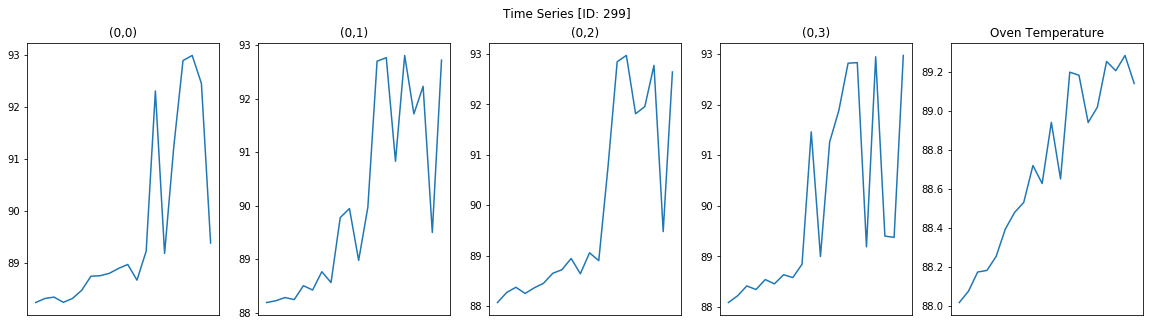

In [9]:
# Step 4. Check temperature time series
def draw_time_series(ts_data_x, ts_data_y, index_start, length):
    oven_cols_index = ts_data_x.shape[1] - 1
    n_parts = 5
    for i in range(index_start, index_start + length):
        fig, axes = plt.subplots(1, n_parts, figsize=(20, 5))
        data_title = 'Time Series [ID: {0}]'.format(ts_data_y[i])
        fig.suptitle(data_title, fontsize=12)
            
        for j in range(n_parts):
            if j == n_parts - 1:
                # Oven temperature
                data_series = ts_data_x[i, oven_cols_index:oven_cols_index+1, :].flatten()
                axes[j].set_title('Oven Temperature')
            else:
                data_series = ts_data_x[i, j:j+1, :].flatten()
                axes[j].set_title('({0},{1})'.format(i, j))
                
            axes[j].get_xaxis().set_visible(False)
            axes[j].plot(data_series)

    plt.show()
    
draw_time_series(x_train, Y_train, 0, 1)

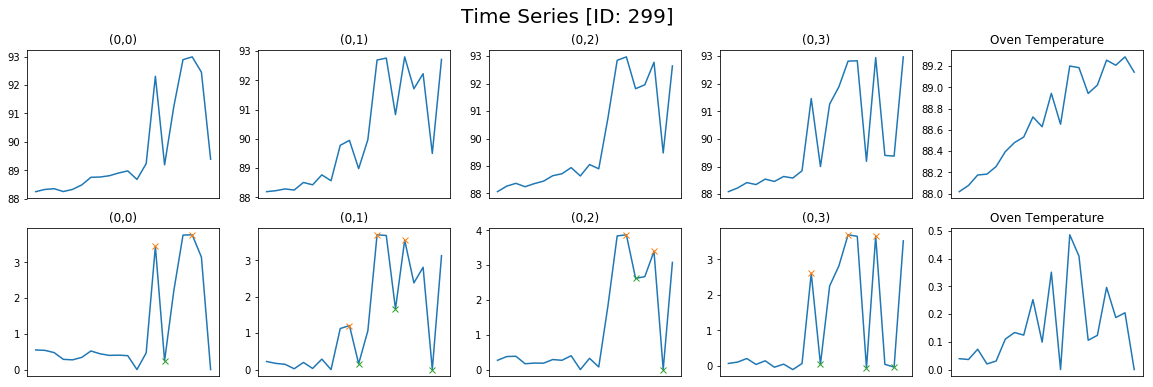

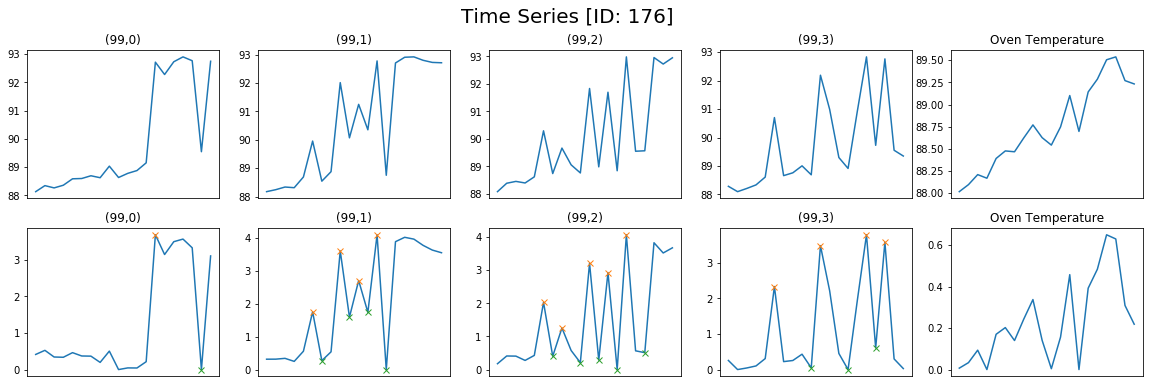

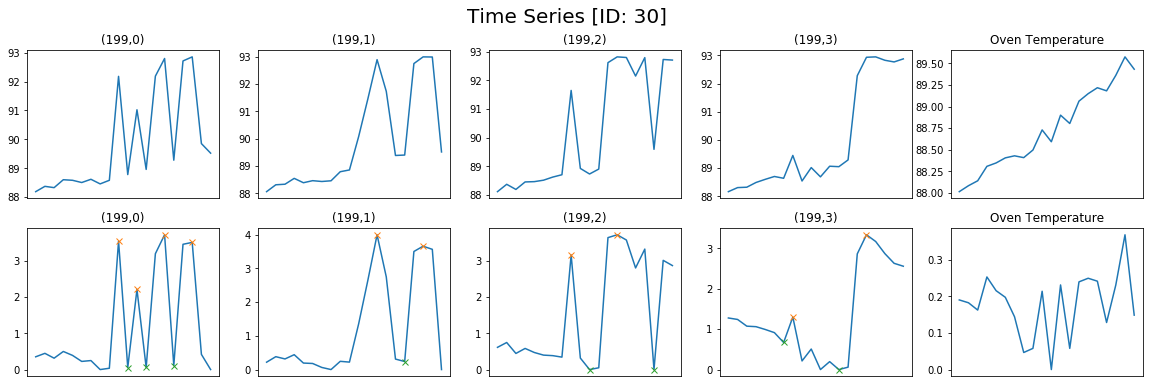

In [10]:
# Step 5. Perform Baseline Correction and Locate peaks and trough
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks as findPeaks

def alsbase(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    
    return z

def corr_baseline(y):
    y_base = alsbase(y, 10^5,0.000005,niter=50)
    corr_y = y - y_base
    return corr_y

def find_series_peaks(ts_data_x, ts_data_y, index_start, length, prominance, distance):
    oven_cols_index = ts_data_x.shape[1] - 1
    n_parts = 5
    for i in range(index_start, index_start + length):
        fig, axes = plt.subplots(2, n_parts, figsize=(20, 6))
        data_title = 'Time Series [ID: {0}]'.format(ts_data_y[i])
        fig.suptitle(data_title, fontsize=20)
        
        for j in range(n_parts):
            if j == n_parts - 1:
                # Oven temperature
                data_series = ts_data_x[i, oven_cols_index:oven_cols_index+1, :].flatten()
                axes[0, j].set_title('Oven Temperature')
            else:
                data_series = ts_data_x[i, j:j+1, :].flatten()
                axes[0, j].set_title('({0},{1})'.format(i, j))
                
            axes[0, j].get_xaxis().set_visible(False)
            axes[0, j].plot(data_series)
        
        for j in range(n_parts):
            if j == n_parts - 1:
                # Oven temperature
                data_series = ts_data_x[i, oven_cols_index:oven_cols_index+1, :].flatten()
                axes[1, j].set_title('Oven Temperature')
            else:
                data_series = ts_data_x[i, j:j+1, :].flatten()
                axes[1, j].set_title('({0},{1})'.format(i, j))
            
            axes[1, j].get_xaxis().set_visible(False)
            
            corr_n = corr_baseline(data_series)
            # Locate peaks
            (pks_n, _) = findPeaks(corr_n, prominence=prominance, distance=distance)
            axes[1, j].plot(corr_n)
            axes[1, j].plot(pks_n, corr_n[pks_n],'x')
            # Locate trough
            (pks_n, _) = findPeaks(corr_n * (-1), prominence=prominance, distance=distance)
            #axes[j].plot(data_series)
            axes[1, j].plot(pks_n, corr_n[pks_n],'x')
            

    plt.show()
   
find_series_peaks(x_train, Y_train, 0, 1, 0.6, 2)
find_series_peaks(x_train, Y_train, 99, 1, 0.6, 2)
find_series_peaks(x_train, Y_train, 199, 1, 0.6, 2)

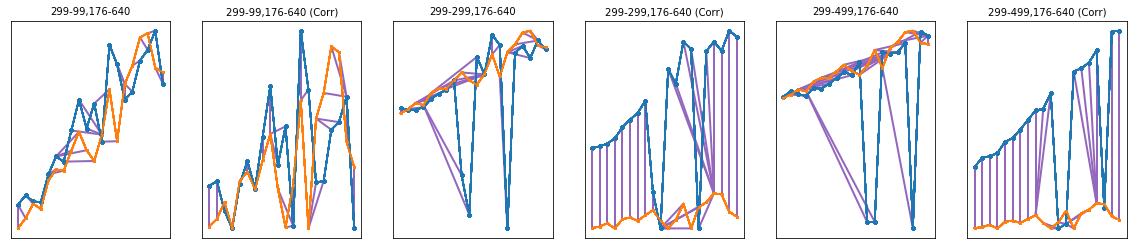

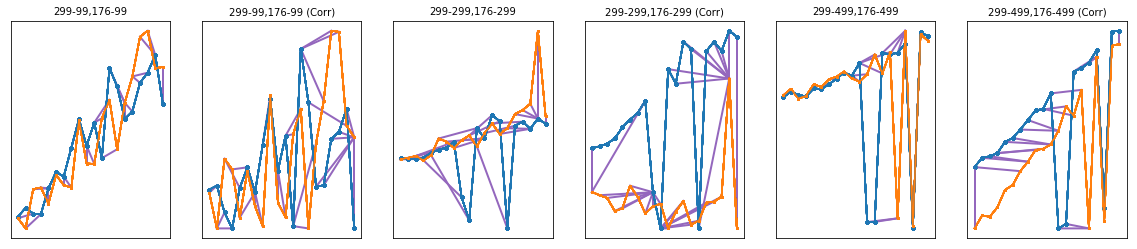

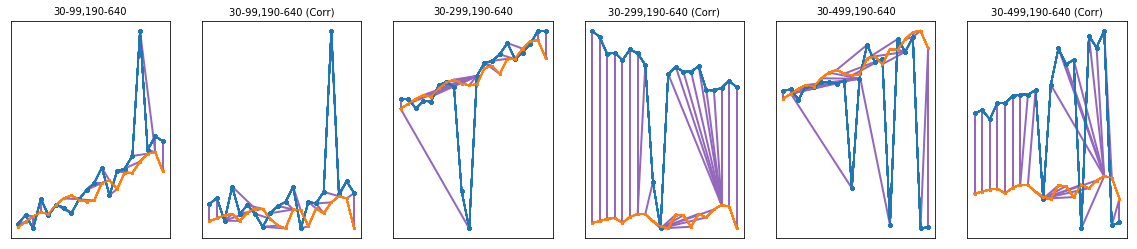

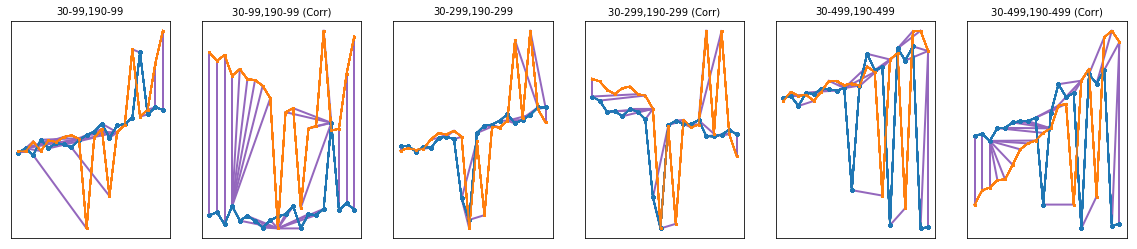

In [11]:
# Step 6. Perform DTW (Dynamic Time Wrapping)

def init_distance(x_series, y_series):
    dists = np.zeros((len(y_series),len(x_series)))
    for i in range(len(y_series)):
        for j in range(len(x_series)):
            dists[i,j] = (y_series[i]-x_series[j])**2
            
    return dists

def pltDistances(dists, title, xlab="X", ylab="Y", clrmap="viridis"):
    #imgplt = plt.figure(figsize=(4, 4))
    plt.suptitle(title, fontsize=20)
    plt.imshow(dists, interpolation='nearest', cmap=clrmap)
    plt.gca().invert_yaxis()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid()
    plt.colorbar()
    
    return imgplt


def compute_acu_cost(dists):
    acuCost = np.zeros(dists.shape)
    acuCost[0,0]= dists[0,0]

    for j in range(1,dists.shape[1]):
        acuCost[0,j] = dists[0,j]+acuCost[0,j-1]
        
    for i in range(1,dists.shape[0]):
        acuCost[i,0] = dists[i,0]+acuCost[i-1,0]
            
    for i in range(1,dists.shape[0]):
        for j in range(1,dists.shape[1]):
            acuCost[i,j] = min(acuCost[i-1,j-1],
                               acuCost[i-1,j],
                               acuCost[i,j-1]) + dists[i,j]
    
    return acuCost


def compute_dfw_path(x_series, y_series, dists, acuCost):
    i = len(y_series) - 1
    j = len(x_series) - 1
    
    path = [[j,i]]
    
    while (i > 0) and (j > 0):
        if i==0:
            j = j-1
        elif j==0:
            i = i-1
        else:
            if acuCost[i-1,j] == min(acuCost[i-1,j-1],
                                      acuCost[i-1,j],
                                      acuCost[i,j-1]):
                i = i-1
            elif acuCost[i,j-1] == min(acuCost[i-1,j-1],
                                        acuCost[i-1,j],
                                        acuCost[i,j-1]):
                j = j-1
            else:
                i = i-1
                j = j-1

        path.append([j,i])
        
    path.append([0,0])

    return path


def plt_warp(s1,s2,path,title, xlab="idx",ylab="Value"):
    #plot_fig = plt.figure(figsize=(4, 4))
    plt.title(title, fontsize=10)
    
    for [idx1,idx2] in path:
        plt.plot([idx1,idx2],[s1[idx1],s2[idx2]],
                 color="C4",
                 linewidth=2)
        plt.plot(s1,
                 'o-',
                 color="C0",
                 markersize=3)
        plt.plot(s2,
                 's-',
                 color="C1",
                 markersize=2)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        
    return plt

def plt_cost_and_path(acuCost,path, title, xlab="X",ylab="Y",clrmap="viridis"):
    px = [pt[0] for pt in path]
    py = [pt[1] for pt in path]
    imgplt = pltDistances(acuCost, 
                          title,
                          xlab=xlab,
                          ylab=ylab,
                          clrmap=clrmap)
    plt.plot(px,py)
    
    return imgplt


def perform_dfw(x_series, y_series, title):
    # Initialize distances
    xy_distances = init_distance(x_series, y_series)
    #pltDistances(xy_distances)
    
    # Compute accumulative cost
    xy_acu_cost = compute_acu_cost(xy_distances)
    #pltDistances(xy_acu_cost, clrmap='Reds')

    # Compute DFW path
    xy_dfw_path = compute_dfw_path(x_series, y_series, 
                                   xy_distances, xy_acu_cost)
    
    # Draw accumulative cost and path 
    #cost_path_fig = plt_cost_and_path(xy_acu_cost, xy_dfw_path, title,
    #                                  clrmap='Reds')

    #plt.show()
    
    # Draw warp on path
    wrap_fit = plt_warp(x_series, y_series, xy_dfw_path, title, 
                        xlab="", ylab="")
    
    #plt.show()

# Perform DFW on OvenTemp and Chip TimeSeries
def perform_dfw_ts(ts_data_x, ts_data_y, ts_data_index_tup, chip_pos_index_tup):
    ts_data_index1, ts_data_index2 = ts_data_index_tup
    chip_pos_index1, chip_pos_index2 = chip_pos_index_tup
    
    chip_ts1 = ts_data_x[ts_data_index1, chip_pos_index1, :].flatten()
    chip_ts2 = ts_data_x[ts_data_index2, chip_pos_index2, :].flatten()
    
    dfw_title = '{0}-{1},{2}-{3}'.format(ts_data_y[ts_data_index1], chip_pos_index1, 
                                         ts_data_y[ts_data_index2], chip_pos_index2)
    perform_dfw(chip_ts1, chip_ts2, dfw_title)

def perform_dfw_ts_correction(ts_data_x, ts_data_y, ts_data_index_tup, chip_pos_index_tup):
    ts_data_index1, ts_data_index2 = ts_data_index_tup
    chip_pos_index1, chip_pos_index2 = chip_pos_index_tup
     
    chip_ts1 = ts_data_x[ts_data_index1, chip_pos_index1, :].flatten()
    chip_ts2 = ts_data_x[ts_data_index2, chip_pos_index2, :].flatten()
    
    chip_corr1 = corr_baseline(chip_ts1)    
    chip_corr2 = corr_baseline(chip_ts2)
    
    dfw_title = '{0}-{1},{2}-{3} (Corr)'.format(ts_data_y[ts_data_index1], chip_pos_index1, 
                                                ts_data_y[ts_data_index2], chip_pos_index2)
    perform_dfw(chip_corr1, chip_corr2, dfw_title)

def perform_dfw_comparison_by_chip_pos(ts_data_x, ts_data_y, ts_data_index_tup, chip_pos_index_list):
   
    chip_pos_index_len = len(chip_pos_index_list)
    rows_plot = int(chip_pos_index_len / 3) + 1
    if chip_pos_index_len % 3 == 0:
        rows_plot -= 1
    
    data_index = 0
    while data_index < chip_pos_index_len:
        cols_plot = 6
        if chip_pos_index_len - data_index < 3:
            cols_plot = (chip_pos_index_len - data_index) * 2
    
        plt.figure(figsize=(20, 4))
                
        for i in range(0, cols_plot, 2):
            subplot_num = int('{0}{1}{2}'.format(1, cols_plot, i + 1))
            
            axes = plt.subplot(subplot_num)
            perform_dfw_ts(ts_data_x, ts_data_y, ts_data_index_tup, chip_pos_index_list[data_index])
            axes.set_xticks([])
            axes.set_yticks([])

            subplot_num = int('{0}{1}{2}'.format(1, cols_plot, i + 2))
            axes = plt.subplot(subplot_num)
            perform_dfw_ts_correction(ts_data_x, ts_data_y, ts_data_index_tup, chip_pos_index_list[data_index])
            axes.set_xticks([])
            axes.set_yticks([])
            
            data_index += 1
        
        plt.show() 
    
def perform_dfw_comparison_by_board_id(ts_data_x, ts_data_y, ts_data_index_list, chip_pos_index_list):
    for ts_index_tup in ts_data_index_list:
        perform_dfw_comparison_by_chip_pos(ts_data_x, ts_data_y, ts_index_tup, chip_pos_index_list)
    
    
# Draw DFW with and without baseline to compare
# 1. Perform DFW regarding oven temperature time series
perform_dfw_comparison_by_board_id(x_train, Y_train, [(0, 99)], [(99, 640), (299, 640), (499, 640)])
# 2. Perform DFW regarding other time series at same position
perform_dfw_comparison_by_board_id(x_train, Y_train, [(0, 99)], [(99, 99), (299, 299), (499, 499)])

# 1. Perform DFW regarding oven temperature time series
perform_dfw_comparison_by_board_id(x_train, Y_train, [(199, 299)], [(99, 640), (299, 640), (499, 640)])
# 2. Perform DFW regarding other time series at same position
perform_dfw_comparison_by_board_id(x_train, Y_train, [(199, 299)], [(99, 99), (299, 299), (499, 499)])


<Figure size 432x288 with 0 Axes>

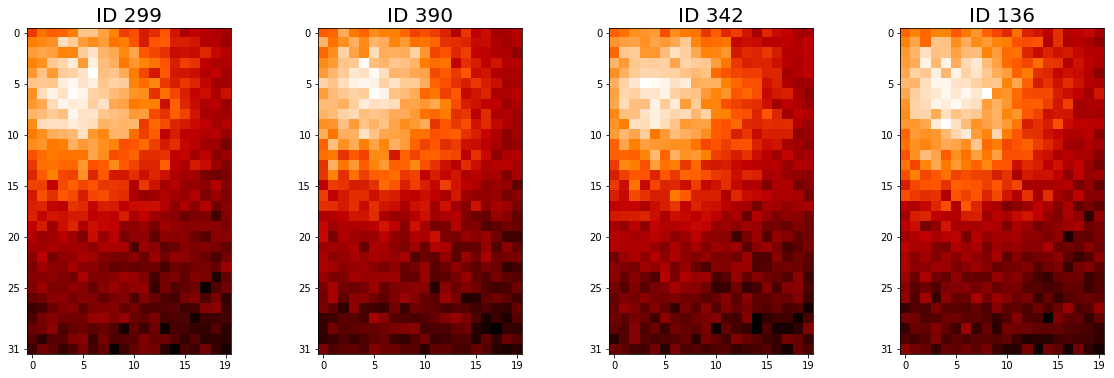

In [12]:
# Plot temperature differences on the burning 

def plt_burn_in_board(ts_data_x, ts_data_y, ts_data_index_list, clrmap="viridis"):
    # Show board in x * 8 grid
    cols_num = 0
    rows_num = 0
    
    data_index_len = len(ts_data_index_list)
    total_rows = int(data_index_len / 8) + 1
    if data_index_len % 8 == 0:
        total_rows = total_rows - 1
    if total_rows == 0:
        total_rows = 1
    
    if total_rows == 1:
        fig, axes = plt.subplots(1, data_index_len, figsize=(20, 6))
    else:
        fig, axes = plt.subplots(total_rows, 8, figsize=(20, 6))
    
    index_num = 0
    
    for data_index in ts_data_index_list:
        oven_data_plt = index_num % 2 == 1
        
        if total_rows == 1:
            if data_index_len == 1:
                plt_axes = axes
            else:
                plt_axes = axes[cols_num]
        else:
            plt_axes = axes[rows_num, cols_num]
            
        #print('subplot_num: ({0}, {1})'.format(rows_num, cols_num))
                
        cols_num += 1
        if cols_num >= 8:
            cols_num = 0
            rows_num += 1
    
        
        # Exclude last oven temp data
        ts_chip_x = ts_data_x[data_index, 0:640, :].reshape(640, 20)
        ts_chip_mean = np.mean(ts_chip_x, axis=1).reshape(32, 20)
        
        #ts_oven_x = ts_data_x[data_index, 640, :].reshape(1, 20)
        #ts_oven_mean = np.mean(ts_oven_x, axis=1)
        
        #ts_x = np.zeros((32, 21))
        #ts_x[:, :-1] = ts_chip_mean
        #ts_x[:, -1] = [ts_oven_mean] * 32
        
        title = 'ID {0}'.format(ts_data_y[data_index])

        #imgplt = plt.figure(figsize=(6, 6))
        plt_axes.set_title(title, fontsize=20)
        #plt.grid(b=True, which='major', axis='both', color='blue', linestyle='-', linewidth=1)
        plt_axes.imshow(ts_chip_mean, interpolation='nearest', cmap=clrmap)
        #plt_axes.set_xlabel(xlab)
        #plt_axes.set_ylabel(ylab)
        # Remove x and y axis ticks
        plt_axes.set_xticks([0, 5, 10, 15, 19])
        plt_axes.set_yticks([0, 5, 10, 15, 20, 25, 31])
        
        index_num += 1

    if total_rows > 1:
        while cols_num < 8 and rows_num < total_rows:
            fig.delaxes(axes[rows_num][cols_num])
            cols_num += 1
        
        
plt.figure()
plt_burn_in_board(x_train, Y_train, range(0, 320, 80), clrmap='gist_heat')
plt.show()

# 2. Build Autoencoder model

In [175]:
# Step 1. Configuration on autoencoder model

# Chips in 1 block which shares the same model
block_chips = 2

# training setup
EPOCHS = 30
BATCH_SIZE = 64

In [176]:
# Step 2. Define an autoencoder model

# Build an autoencoder model
encoder_dimension = int(32 * 20 / block_chips)
abnormal_threshold = 1000

def build_AE(x_train, encoder_dim=encoder_dimension):
    # input placeholder
    signal_dim = x_train.shape[1]
    input_image = Input(shape=(signal_dim, ))

    # encoding layer
    hidden_layer = Dense(encoder_dim, activation='relu')(input_image)

    # decoding layer
    decode_output = Dense(signal_dim, activation='relu')(hidden_layer)

    # build autoencoder, encoder, decoder
    encoder = Model(inputs=input_image, outputs=hidden_layer)
    autoencoder = Model(inputs=input_image, outputs=decode_output)

    # compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    # training
    autoencoder.fit(x_train, x_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True)

    return encoder, autoencoder


# Perform prediction using the trained autoencoder model
def compute_dist(data_in, autoencoder_in, threshold=10):
    print(data_in.shape)

    data_dist = []
    
    for i in range(len(data_in)):
        # Step 1: Select the test sample (such as the 0-th sample)
        test_data_orig = data_in[i:i+1,:]
        
        # Step 2: Perform prediction using the trained autoencoder model
        test_data_predict = autoencoder_in.predict(test_data_orig)

        # Step 3: Calculate the reconstruction error and make decision on anomaly detection
        dist = np.linalg.norm(test_data_orig - test_data_predict, axis=-1)
        data_dist.append(dist)
        
        if dist > threshold:
            print('Anomaly detected (distance: %.2f)' % dist)
        else:
            #print('Normal (distance: %.2f)' % dist)
            pass
        
    return np.array(data_dist)

In [177]:
# Show the encoding coefficients

def show_encodings(inputs, outputs):
    n = len(inputs)
    #print('len(inputs): ', n)
    fig, axes = plt.subplots(2, n)
    for i in range(n):
        axes[0, i].imshow(inputs[i].reshape(-1, 20), cmap='gray')
        axes[1, i].imshow(outputs[i].reshape(-1, 20), cmap='gray')
    for ax in axes.flatten():
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


(320, 2, 20) (80, 2, 20)


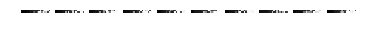

(320, 40) (80, 40)


In [178]:
# Remove oven temperature time series
#ae_data_train = x_train[:, 420:421]
#ae_data_test = x_test[:, 420:421]

ae_data_train = x_train[:, 0:block_chips]
ae_data_test = x_test[:, 0:block_chips]
print(ae_data_train.shape, ae_data_test.shape)

ae_data_max = np.amax(ae_data_train)

# Normalize
ae_data_train = ae_data_train.astype('float32') * 255 / ae_data_max
ae_data_test = ae_data_test.astype('float32') * 255 / ae_data_max

# Plot the examples of original images
fig, ax = plt.subplots(1, 10)
for i in range(10):
    ax[i].imshow(ae_data_train[i], cmap='gray')
    ax[i].axis('off')

plt.show()

ae_data_train = ae_data_train.reshape((ae_data_train.shape[0], -1))
ae_data_test = ae_data_test.reshape((ae_data_test.shape[0], -1))
print(ae_data_train.shape, ae_data_test.shape)

In [179]:
# Train the model
model_encoder, model_autoencoder = build_AE(x_train=ae_data_train)

# Plot the model summary
model_encoder.summary()
model_autoencoder.summary()

Epoch 1/30
320/320 [==============================] - 1s 2ms/step - loss: 32059.8082
Epoch 2/30
320/320 [==============================] - 0s 44us/step - loss: 25414.7105
Epoch 3/30
320/320 [==============================] - 0s 47us/step - loss: 24615.7332
Epoch 4/30
320/320 [==============================] - 0s 50us/step - loss: 23399.2543
Epoch 5/30
320/320 [==============================] - 0s 40us/step - loss: 22272.0676
Epoch 6/30
320/320 [==============================] - 0s 44us/step - loss: 21852.7184
Epoch 7/30
320/320 [==============================] - 0s 47us/step - loss: 21779.0867
Epoch 8/30
320/320 [==============================] - 0s 40us/step - loss: 21644.8266
Epoch 9/30
320/320 [==============================] - 0s 34us/step - loss: 21536.0398
Epoch 10/30
320/320 [==============================] - 0s 41us/step - loss: 21530.0605
Epoch 11/30
320/320 [==============================] - 0s 34us/step - loss: 21503.1980
Epoch 12/30
320/320 [==============================] 

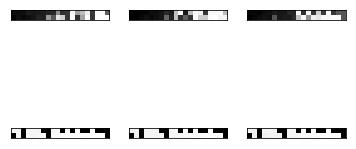

In [180]:
# Visualize the results

num_sample = 3 # Number of test samples used for visualization
data_rec = model_autoencoder.predict(ae_data_test)
show_encodings(ae_data_test[:num_sample], data_rec)

In [181]:
# Calculate the reconstruction error and make decision on anomaly detection
data_dist = compute_dist(ae_data_test, model_autoencoder, threshold=abnormal_threshold)
print('data_dist: ', data_dist.shape)

(80, 40)
data_dist:  (80, 1)


In [182]:
# Determine the test data (row index) with LARGEST reconstruction error based on trained model
max_dist_index = np.unravel_index(np.argmax(data_dist, axis=None), data_dist.shape)
print("test data row index ({0}) with LARGEST reconstruction error".format(max_dist_index[0]))

# Determine the test data (row index) with LOWEST reconstruction error based on trained model
min_dist_index = np.unravel_index(np.argmin(data_dist, axis=None), data_dist.shape)
print("test data row index ({0}) with LOWEST reconstruction error".format(min_dist_index[0]))

min_dist = data_dist[min_dist_index]
max_dist = data_dist[max_dist_index]

print("minimum error: {0:.2f}".format(min_dist))
print("maximum error: {0:.2f}".format(max_dist))
print("distance from max to min error: {0:.2f}".format(max_dist - min_dist))

test data row index (25) with LARGEST reconstruction error
test data row index (2) with LOWEST reconstruction error
minimum error: 920.79
maximum error: 934.05
distance from max to min error: 13.26
